#### Image Captioning - InceptionV3 +GRU

####Copyright 2018 The TensorFlow Authors.

###### @title Licensed under the Apache License, Version 2.0 (the "License") you may not use this file except in compliance with the License.

####You may obtain a copy of the License at https://www.apache.org/licenses/LICENSE-2.0¶

####Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.

####See the License for the specific language governing permissions and limitations under the License.

# Image Captioning이란?


이미지 캡셔닝은 이미지 속 정보를 묘사하여 설명해주는 기술입니다. 이미지 캡셔닝은 영상 또는 이미지를 처리하는 컴퓨터 비전 분야와 자연어 텍스트를 처리하는 자연어처리 분야의 학제적 연구 분야로 컴퓨터 비전과 자연어처리를 연결하는 인공지능 기술입니다. 본 파일에서는 대표적인 농작물 중 하나인 '고추' 이미지를 활용하여 정상 고추 이미지와 질병이 있는 고추 이미지에 대한 캡션 생성 모델을 구현했습니다.

이 모델은  [Show, Attend and Tell: Neural Image Caption Generation with Visual Attention](https://arxiv.org/abs/1502.03044) 논문을 기반으로 합니다.

이 파일에서는 Attention 기법을 적용한 End-To-End 방식의 이미지 캡셔닝 모델을 구현하였습니다. [AI HUB에서 제공한 '노지 작물 질병 진단 이미지'](https://www.aihub.or.kr/aihubdata/data/view.do?currMenu=115&topMenu=100&aihubDataSe=realm&dataSetSn=147)의 이미지를 이용자가 직접 업로드하면, CNN 계열 모델 중 하나인 InceptionV3를 이용해 이미지 전처리 및 캐시 처리한 후, 추출해낸 Feature 값과 이미지에 대한 정답 캡션을 RNN 계열의 모델인 GRU에 입력해 모델을 훈련합니다. 이때 모델은 Attention 기법에 의해 문장 생성시 feature값들 중에서 어떤 feature에 집중해야 되는지 살피게 됩니다. 훈련된 모델을 활용해 새로운 이미지에 대한 캡션을 생성하도록 하고, 문장 생성 성능을 BLEU 스코어를 통해 평가합니다.




---
# Image-captioning-pepper_prototype

In [1]:
import tensorflow as tf

import matplotlib.pyplot as plt
from tensorflow import keras
import collections
import random
import numpy as np
import pandas as pd
import os
import time
import json
from PIL import Image
from tqdm import tqdm

from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction

plt.rc('font', family = 'NanumBarunGothic')

In [ ]:
#코랩 한글폰트 설치(쉘 실행 후 런타임 다시 시작 필요)
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

In [2]:
import tensorflow as tf
print(tf.__version__)
print(tf.test.is_built_with_cuda())
print(tf.test.is_built_with_gpu_support())
print(tf.test.gpu_device_name())

2.8.2
True
True
/device:GPU:0


# Pepper Dataset

In [9]:
image_folder ='/content/drive/MyDrive/pepper_dataset/plant_dataset/노지 작물 질병 진단 이미지/고추전체/고추이미지all/'
PATH = image_folder

In [10]:
annotations = pd.read_csv("/content/drive/MyDrive/pepper_dataset/plant_dataset/pepper_merged.csv", encoding='cp949').drop("Unnamed: 0", axis=1)
annotations.head()

,images,captions
0,V006_79_1_01_01_01_13_1_0149z_20201007_1.JPG,고추에 움푹 들어간 원형 반점이 나타나는 것으로 보아 고추탄저병으로 의심됩니다
1,V006_79_1_01_01_01_13_1_0149z_20201007_1.JPG,고추에 원형 반점이 움푹 들어나는 양상을 보여 고추탄저병으로 의심됩니다
2,V006_79_1_01_01_01_13_1_0149z_20201007_1.JPG,고추에 원형 반점이 나타나 고추탄저병으로 의심됩니다
3,V006_79_1_01_01_01_13_1_0149z_20201007_1.JPG,고추에 원형 반점이 생긴 것으로 보아 고추탄저병으로 의심됩니다
4,V006_79_1_01_01_01_13_1_0149z_20201007_1.JPG,고추에 원형 반점이 움푹 들어간 것으로 보아 고추탄저병으로 의심됩니다


### Group all captions together having the same image ID.
* `<start> <end>` 붙여주기
* `image_path` 정의
* `image_path_to_caption` 정의

In [11]:
annotations['captions'] = annotations['captions'].apply(lambda x: '<start> ' + x + ' <end>')
annotations.head()

,images,captions
0,V006_79_1_01_01_01_13_1_0149z_20201007_1.JPG,<start> 고추에 움푹 들어간 원형 반점이 나타나는 것으로 보아 고추탄저병으로 ...
1,V006_79_1_01_01_01_13_1_0149z_20201007_1.JPG,<start> 고추에 원형 반점이 움푹 들어나는 양상을 보여 고추탄저병으로 의심됩니...
2,V006_79_1_01_01_01_13_1_0149z_20201007_1.JPG,<start> 고추에 원형 반점이 나타나 고추탄저병으로 의심됩니다 <end>
3,V006_79_1_01_01_01_13_1_0149z_20201007_1.JPG,<start> 고추에 원형 반점이 생긴 것으로 보아 고추탄저병으로 의심됩니다 <end>
4,V006_79_1_01_01_01_13_1_0149z_20201007_1.JPG,<start> 고추에 원형 반점이 움푹 들어간 것으로 보아 고추탄저병으로 의심됩니다...


In [12]:
print(len(annotations))

120815


* defualtdictionary 형식의 image_path_to_caption 에 (key)1개 이미지 경로 당, (values)5개 caption을 한 리스트로 생성  

In [13]:
image_path_to_caption = collections.defaultdict(list)
for i in range(len(annotations)):
    image_path = PATH + annotations.images[i]
#     print(image_path, '\n')
    image_path_to_caption[image_path].append(annotations.captions[i])
#     print(image_path_to_caption)
print(image_path)
print(image_path_to_caption[image_path])

/content/drive/MyDrive/pepper_dataset/plant_dataset/노지 작물 질병 진단 이미지/고추전체/고추이미지all/V006_79_0_00_01_03_13_0_c44_20201026_0001_S01_1.jpg
['<start> 고추에 이상 징후가 발견되지 않아 정상 고춧잎으로 사료됩니다 <end>', '<start> 특별한 이상 징후가 없는 고춧잎으로 판단됩니다 <end>', '<start> 병에 대한 증상이 나타나지 않는 정상 고춧잎으로 판단됩니다 <end>', '<start> 병의 증세가 나타나지 않는 정상적인 고춧잎으로 판단됩니다 <end>', '<start> 고춧잎에 특별한 병의 증세가 나타나지 않아 정상으로 판단됩니다 <end>']


* train_image_paths 에 image 들의 이름(key)들만을 리스트로 정의 
    * shuffle 로 섞어주기
* 이미지에 대한 전체 캡션을 사용

In [14]:
image_paths = list(image_path_to_caption.keys())
random.shuffle(image_paths)

train_image_paths = image_paths #[:6000]
print(len(train_image_paths))
# print(train_image_paths)

24163


In [15]:
train_captions = []
img_name_vector = []

for image_path in train_image_paths:
#     print(image_path_to_caption[image_path],'\n')
    caption_list = image_path_to_caption[image_path]
    train_captions.extend(caption_list)
#     print(len(caption_list))
    img_name_vector.extend([image_path] * len(caption_list))
print('캡션 예시:')
for w in train_captions[:6]:
    print(w)
print()
print("파일 경로 예시:")
for w in img_name_vector[:6]:
    print(w)

캡션 예시:
<start> 움푹 들어간 원형 반점과 황갈색의 포자덩어리가 나타나고 고추가 말라 비틀어진 것으로 보아 고추탄저병으로 의심됩니다 <end>
<start> 고추에 원형 반점과 황갈색 포자덩어리가 나타나고 말라 비틀어진 것을 보아 고추탄저병으로 의심됩니다 <end>
<start> 황갈색 포자덩어리와 원형반점이 고추에 생겼고 말라 비틀어진 것으로 보아 고추탄저병으로 의심됩니다 <end>
<start> 고추가 말라 비틀어지고 황갈색 포자덩어리와 원형반점이 생긴 것으로 보아 고추탄저병으로 의심됩니다 <end>
<start> 고추가 말라 비틀어지고 원형반점과 황갈색 포자덩어리가 발견되어 고추탄저병으로 사료됩니다  <end>
<start> 고추에 이상 징후가 발견되지 않아 정상 고춧잎으로 사료됩니다 <end>

파일 경로 예시:
/content/drive/MyDrive/pepper_dataset/plant_dataset/노지 작물 질병 진단 이미지/고추전체/고추이미지all/V006_79_1_01_01_01_13_3_9315z_20201119_5_a0007.JPG
/content/drive/MyDrive/pepper_dataset/plant_dataset/노지 작물 질병 진단 이미지/고추전체/고추이미지all/V006_79_1_01_01_01_13_3_9315z_20201119_5_a0007.JPG
/content/drive/MyDrive/pepper_dataset/plant_dataset/노지 작물 질병 진단 이미지/고추전체/고추이미지all/V006_79_1_01_01_01_13_3_9315z_20201119_5_a0007.JPG
/content/drive/MyDrive/pepper_dataset/plant_dataset/노지 작물 질병 진단 이미지/고추전체/고추이미지al

## InceptionV3를 사용하여 이미지 전처리하기

다음으로, Imagenet에 대해 사전 훈련된 InceptionV3를 사용하여 이미지를 분석하고 마지막 Convolutional Layer에서 특징을 추출해냅니다.

- 이미지를 299px x 299px로 resize합니다.
- [InceptionV3 설명](https://www.tensorflow.org/api_docs/python/tf/keras/applications/inception_v3/preprocess_input)

In [16]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

## InceptionV3 초기화 및 사전 훈련된 Imagenet 가중치 로드하기

이제 Output Layer가 InceptionV3의 마지막 Convolutional Layer인 tf.keras 모델을 만듭니다.

- 네트워크를 통해 각 이미지를 전달하고 결과 벡터를 사전 (image_name --&gt; feature_vector)에 저장합니다.
- 모든 이미지가 네트워크를 통해 전달된 후, 사전을 디스크에 저장합니다.

In [17]:
image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

87924736/87910968 [==============================] - 0s 0us/step


In [18]:
print(image_features_extract_model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, None, None,   96         ['conv2d[0][0]']                 
 alization)                     32)                                                           

## InceptionV3에서 추출된 특징 캐시하기

InceptionV3로 각 이미지를 사전 처리하고 출력을 디스크에 캐시합니다. 현재 코드보다 정교한 캐싱 전략(ex. 임의 액세스 디스크 I/O를 줄이기 위해 이미지 분할 등)으로 성능을 향상할 수 있습니다.


In [22]:
# 중복 없는 이미지만 갖고 옴
encode_train = sorted(set(img_name_vector))


image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE).batch(16)

#이미지에서 추출한 특징 캐시하기
for img, path in tqdm(image_dataset):
    batch_features = image_features_extract_model(img)
    batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))

    for bf, p in zip(batch_features, path):
        path_of_feature = p.numpy().decode("utf-8")
        np.save(path_of_feature, bf.numpy())

100%|██████████| 1511/1511 [4:17:54<00:00, 10.24s/it]


## 캡션 전처리 및 토큰화하기

- 캡션을 토큰화합니다. 그리고 최대 단어의 크기를 상위 10,000개 단어로 제한합니다. 
그 단어 이외의 단어들은 토큰 "UNK"(알 수 없음)로 대체됩니다.
- 그 후, 단어 대 인덱스 및 인덱스 대 단어 매핑을 만듭니다.
- 마지막으로, 모든 시퀀스를 가장 긴 시퀀스와 같은 길이로 채웁니다.

In [19]:
# 캡션 데이터에서 가장 길이가 긴 문장의 길이를 구함
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

In [21]:
print(len(train_captions))

120815


In [22]:
# keras에서 제공하는 토크나이저로 캡션을 토큰화함
# 토큰화할 때 전체 토큰에서 빈도가 높은 상위 10000개의 단어만 사용함
top_k = 10000
#oov = outofvocabulary 즉, 상위 10000개의 단어에 해당하지 않는 단어는 모두 사전에 없는 단어로 간주하여 oov로 처리함
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~')
tokenizer.fit_on_texts(train_captions)
# print(train_captions)

In [23]:
#단어 : 인덱스
print(tokenizer.word_index)

{'<unk>': 1, '<start>': 2, '<end>': 3, '의심됩니다': 4, '보아': 5, '것으로': 6, '고추에': 7, '고추탄저병으로': 8, '고추흰가루병으로': 9, '담황색': 10, '원형': 11, '말라': 12, '비틀어진': 13, '나타나고': 14, '발견되어': 15, '황갈색의': 16, '황갈색': 17, '같은': 18, '나타나는': 19, '사료됩니다': 20, '포자덩어리와': 21, '움푹': 22, '병무늬가': 23, '들어간': 24, '반점이': 25, '잎에': 26, '포자와': 27, '포자덩어리가': 28, '포자가': 29, '반점과': 30, '연한': 31, '흰색': 32, '않아': 33, '특별한': 34, '판단됩니다': 35, '서릿발': 36, '모양의': 37, '이슬과': 38, '원형반점이': 39, '증상이': 40, '곰팡이가': 41, '것을': 42, '반점무늬가': 43, '바른': 44, '것과': 45, '발견되지': 46, '생긴': 47, '나타나며': 48, '넓게': 49, '고추가': 50, '이상이': 51, '없는': 52, '원형반점과': 53, '밀가루를': 54, '얇은': 55, '고춧잎으로': 56, '이상': 57, '징후가': 58, '정상': 59, '나타나지': 60, '고추로': 61, '비틀어지고': 62, '보여': 63, '말라비틀어진': 64, '고추탄저병이': 65, '곰팡이와': 66, '않는': 67, '병의': 68, '증세가': 69, '고춧잎에': 70, '병무늬와': 71, '밀가루': 72, '반점무늬와': 73, '보이고': 74, '생겼고': 75, '없다고': 76, '보이지': 77, '아무': 78, '병에': 79, '대한': 80, '정상적인': 81, '정상으로': 82, '보이는': 83, '발견되므로': 84, '고춧잎에서': 85, '고추에서는': 86, '곳으로': 87, '고추에서'

In [24]:
#패딩 토큰은 0으로 대응시킴
#이를 토크나이저에 반영함
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [25]:
#인덱스 : 단어
print(tokenizer.index_word)

{1: '<unk>', 2: '<start>', 3: '<end>', 4: '의심됩니다', 5: '보아', 6: '것으로', 7: '고추에', 8: '고추탄저병으로', 9: '고추흰가루병으로', 10: '담황색', 11: '원형', 12: '말라', 13: '비틀어진', 14: '나타나고', 15: '발견되어', 16: '황갈색의', 17: '황갈색', 18: '같은', 19: '나타나는', 20: '사료됩니다', 21: '포자덩어리와', 22: '움푹', 23: '병무늬가', 24: '들어간', 25: '반점이', 26: '잎에', 27: '포자와', 28: '포자덩어리가', 29: '포자가', 30: '반점과', 31: '연한', 32: '흰색', 33: '않아', 34: '특별한', 35: '판단됩니다', 36: '서릿발', 37: '모양의', 38: '이슬과', 39: '원형반점이', 40: '증상이', 41: '곰팡이가', 42: '것을', 43: '반점무늬가', 44: '바른', 45: '것과', 46: '발견되지', 47: '생긴', 48: '나타나며', 49: '넓게', 50: '고추가', 51: '이상이', 52: '없는', 53: '원형반점과', 54: '밀가루를', 55: '얇은', 56: '고춧잎으로', 57: '이상', 58: '징후가', 59: '정상', 60: '나타나지', 61: '고추로', 62: '비틀어지고', 63: '보여', 64: '말라비틀어진', 65: '고추탄저병이', 66: '곰팡이와', 67: '않는', 68: '병의', 69: '증세가', 70: '고춧잎에', 71: '병무늬와', 72: '밀가루', 73: '반점무늬와', 74: '보이고', 75: '생겼고', 76: '없다고', 77: '보이지', 78: '아무', 79: '병에', 80: '대한', 81: '정상적인', 82: '정상으로', 83: '보이는', 84: '발견되므로', 85: '고춧잎에서', 86: '고추에서는', 87: '곳으로', 88: '고

In [26]:
# 각 토큰의 인덱스(숫자)로 문장마다 벡터로 표현함
train_seqs = tokenizer.texts_to_sequences(train_captions)

In [27]:
#각 토큰은 인덱스(숫자)로 변환되었고 하나의 문장에 대한 토큰들이 숫자의 나열인 '벡터'로 표현됨
print(train_seqs[:2])

[[2, 22, 24, 11, 30, 16, 28, 14, 50, 12, 13, 6, 5, 8, 4, 3], [2, 7, 11, 30, 17, 28, 14, 12, 13, 42, 5, 8, 4, 3]]


In [28]:
# 각 문장 벡터를 가장 길이가 긴 문장의 길이에 맞춰 패딩을 추가하여 벡터로 표현함
# 최대 길이를 설정하는 값을 지정해주지 않으면 pad_sequences 함수가 자동으로 가장 긴 문장에 맞춰 패딩을 함
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')
print(cap_vector[:10])

[[ 2 22 24 11 30 16 28 14 50 12 13  6  5  8  4  3]
 [ 2  7 11 30 17 28 14 12 13 42  5  8  4  3  0  0]
 [ 2 17 21 39  7 75 12 13  6  5  8  4  3  0  0  0]
 [ 2 50 12 62 17 21 39 47  6  5  8  4  3  0  0  0]
 [ 2 50 12 62 53 17 28 15  8 20  3  0  0  0  0  0]
 [ 2  7 57 58 46 33 59 56 20  3  0  0  0  0  0  0]
 [ 2 34 57 58 52 56 35  3  0  0  0  0  0  0  0  0]
 [ 2 79 80 40 60 67 59 56 35  3  0  0  0  0  0  0]
 [ 2 68 69 60 67 81 56 35  3  0  0  0  0  0  0  0]
 [ 2 70 34 68 69 60 33 82 35  3  0  0  0  0  0  0]]


In [29]:
# 캡션 문장의 최장 길이를 계산하고 나중에 어텐션 가중치에 그 값을 저장함
max_length = calc_max_length(train_seqs)

## 데이터를 훈련(Train) 및 평가(Validation) 데이터셋로 분할하기




In [30]:
img_to_cap_vector = collections.defaultdict(list)
for img, cap in zip(img_name_vector, cap_vector):
    img_to_cap_vector[img].append(cap)

# 랜덤으로 80:20의 비율로 훈련데이터와 검증데이터로 분할함.
img_keys = list(img_to_cap_vector.keys())
random.shuffle(img_keys)

slice_index = int(len(img_keys)*0.8)
img_name_train_keys, img_name_val_keys = img_keys[:slice_index], img_keys[slice_index:]

img_name_train = []
cap_train = []
for imgt in img_name_train_keys:
    capt_len = len(img_to_cap_vector[imgt])
    img_name_train.extend([imgt] * capt_len)
    cap_train.extend(img_to_cap_vector[imgt])

img_name_val = []
cap_val = []
for imgv in img_name_val_keys:
    capv_len = len(img_to_cap_vector[imgv])
    img_name_val.extend([imgv] * capv_len)
    cap_val.extend(img_to_cap_vector[imgv])

## 훈련을 위한 tf.data 데이터세트 생성하기


이미지와 캡션이 준비되었습니다. 다음으로 모델 훈련에 사용할 `tf.data` 데이터세트를 만듭니다.

In [31]:
# 훈련에 사용될 하이퍼파라미터 정의
BATCH_SIZE = 64
BUFFER_SIZE = 1000
EPOCHS = 20
embedding_dim = 256
units = 512
vocab_size = top_k + 1
num_steps = len(img_name_train) // BATCH_SIZE

# InceptionV3에서 추출된 벡터의 모양은 
# (64, 2048) == (attention_features_shape, features_shape) 이다
# 즉, 아래의 두 변수로 벡터의 모양이 결정된다
features_shape = 2048
attention_features_shape = 64

In [32]:
# 이미지 특징 추출 직후 디스크에 캐시한 넘파이 형태의 파일을 불러옴
def map_func(img_name, cap):
    img_tensor = np.load(img_name.decode('utf-8')+'.npy')
    return img_tensor, cap

In [33]:
#훈련데이터셋 처리
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# map 함수로 넘파이 파일을 평행적으로 불러옴
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.AUTOTUNE)

# 데이터를 뒤섞고 배치 사이즈에 맞게 데이터를 묶음으로 구분함
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

In [34]:
#검증데이터셋 처리
val_dataset = tf.data.Dataset.from_tensor_slices((img_name_val, cap_val))

# map 함수로 넘파이 파일을 평행적으로 불러옴
val_dataset = val_dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.AUTOTUNE)

# 데이터를 뒤섞고 배치 사이즈에 맞게 데이터를 묶음으로 구분함
val_dataset = val_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
val_dataset = val_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

## 모델

모델은 Encoder로 CNN을 Decoder로 RNN을 활용합니다. 
- CNN에서는 이미지의 Feature들을 추출해낸 후, 
- 추출한 Feature들을 RNN을 통해서 단어 토큰으로 출력하는 구조로 이루어집니다. 

In [35]:
class BahdanauAttention(tf.keras.Model):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, features, hidden):
        # CNN 인코더에서 나온 결과물의 모양 == (batch_size, 100, embedding_dim)

        # hidden shape == (batch_size, hidden_size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
        hidden_with_time_axis = tf.expand_dims(hidden, 1)

        # attention_hidden_layer shape == (batch_size, 100, units)
        attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
                                             self.W2(hidden_with_time_axis)))

        # score shape == (batch_size, 100, 1)
        #각 이미지 특징에 대한 정규화되지 않은 점수 산출
        score = self.V(attention_hidden_layer)

        # attention_weights shape == (batch_size, 100, 1) 
        attention_weights = tf.nn.softmax(score, axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [36]:
class CNN_Encoder(tf.keras.Model):
    # 이 인코더에서는 이미지에서 추출된 특징을 완전연결층에 전달한다.
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # 완전연결층을 지난 뒤 특징벡터의 모양 == (batch_size, 100, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [37]:
class RNN_Decoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size):
        super(RNN_Decoder, self).__init__()
        self.units = units

        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc1 = tf.keras.layers.Dense(self.units)
        self.fc2 = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.units)

    def call(self, x, features, hidden):
        # Attention을 별개의 모델로 정의함
        context_vector, attention_weights = self.attention(features, hidden)

        # 임베딩을 거친 뒤의 x 벡터 모양 == (batch_size, 1, embedding_dim)
        x = self.embedding(x)

        # concatenation 한 뒤의 x 벡터 모양 == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        # concatenate 된 vector를 GRU 모델에 전달함
        output, state = self.gru(x)

        # 벡터 모양 == (batch_size, max_length, hidden_size)
        x = self.fc1(output) #완전연결층에 전달

        # x shape == (batch_size * max_length, hidden_size)
        x = tf.reshape(x, (-1, x.shape[2]))

        # output shape == (batch_size * max_length, vocab)
        x = self.fc2(x)

        return x, state, attention_weights

    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [38]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

In [39]:
#옵티마이저와 손실함수를 정의
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

## 체크포인트

In [40]:
checkpoint_path = "/content/drive/MyDrive/pepper_dataset/plant_dataset/노지 작물 질병 진단 이미지/고추전체/attention_ckpt"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [41]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
    # 가장 최신의 체크포인트를 계속 저장함
    ckpt.restore(ckpt_manager.latest_checkpoint)

## 훈련하기

- 각 `.npy` 파일에 저장된 특성을 추출한 다음, 해당 특성을 endcoder를 통해 전달합니다.
- encoder의 출력값, decoder의 hidden state(0으로 초기화됨) 및 입력값(start token)이 decoder로 전달됩니다.
- decoder는 예측값 및 decoder hidden state를 반환합니다.
- 그 후 decoder hidden state가 모델로 다시 전달되고, 예측값은 손실을 계산하는 데 사용됩니다. 
- teacher forcing를 사용하여 decoder에 대한 다음 입력을 결정합니다. teacher forcing은 출력값이, 다음 입력값으로 decoder에 전달되는 기법입니다.
- 마지막으로 Gradient를 계산하고 이를 Optimizer에 적용하여 Back-propagation합니다.


In [43]:
# loss 값을 그리기 위해 loss 값들을 담는 리스트인 loss_plot을 생성
loss_plot = []

In [42]:
print(tokenizer.word_index)

{'<unk>': 1, '<start>': 2, '<end>': 3, '의심됩니다': 4, '보아': 5, '것으로': 6, '고추에': 7, '고추탄저병으로': 8, '고추흰가루병으로': 9, '담황색': 10, '원형': 11, '말라': 12, '비틀어진': 13, '나타나고': 14, '발견되어': 15, '황갈색의': 16, '황갈색': 17, '같은': 18, '나타나는': 19, '사료됩니다': 20, '포자덩어리와': 21, '움푹': 22, '병무늬가': 23, '들어간': 24, '반점이': 25, '잎에': 26, '포자와': 27, '포자덩어리가': 28, '포자가': 29, '반점과': 30, '연한': 31, '흰색': 32, '않아': 33, '특별한': 34, '판단됩니다': 35, '서릿발': 36, '모양의': 37, '이슬과': 38, '원형반점이': 39, '증상이': 40, '곰팡이가': 41, '것을': 42, '반점무늬가': 43, '바른': 44, '것과': 45, '발견되지': 46, '생긴': 47, '나타나며': 48, '넓게': 49, '고추가': 50, '이상이': 51, '없는': 52, '원형반점과': 53, '밀가루를': 54, '얇은': 55, '고춧잎으로': 56, '이상': 57, '징후가': 58, '정상': 59, '나타나지': 60, '고추로': 61, '비틀어지고': 62, '보여': 63, '말라비틀어진': 64, '고추탄저병이': 65, '곰팡이와': 66, '않는': 67, '병의': 68, '증세가': 69, '고춧잎에': 70, '병무늬와': 71, '밀가루': 72, '반점무늬와': 73, '보이고': 74, '생겼고': 75, '없다고': 76, '보이지': 77, '아무': 78, '병에': 79, '대한': 80, '정상적인': 81, '정상으로': 82, '보이는': 83, '발견되므로': 84, '고춧잎에서': 85, '고추에서는': 86, '곳으로': 87, '고추에서'

In [44]:
print(tokenizer.word_index['<unk>'])

1


In [45]:
@tf.function
def train_step(img_tensor, target):
    loss = 0

    # 각 batch마다 은닉층을 초기화한다
    # 각 이미지의 캡션은 서로 관련이 없기 때문. 즉, 각 이미지의 캡션은 서로 독립적인 관계임
    hidden = decoder.reset_state(batch_size=target.shape[0])
#     print(tokenizer.word_index)
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

    with tf.GradientTape() as tape:
        features = encoder(img_tensor) #추출된 특징을 인코더에서 완전연결층에 전달하여 처리

        for i in range(1, target.shape[1]):
            #인코더에서 처리된 특징을 디코더에 전달함
            predictions, hidden, _ = decoder(dec_input, features, hidden)

            loss += loss_function(target[:, i], predictions)

            #teacher forcing으로 출력값이 다시 입력값으로 디코더에 전달되도록 함
            dec_input = tf.expand_dims(target[:, i], 1)

    total_loss = (loss / int(target.shape[1]))

    trainable_variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, trainable_variables)

    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss, total_loss


    

- Epoch는 다음 학습을 몇 번 반복할 지를 결정합니다. 
- Default 값으로는 20번으로 지정되어있습니다.
- 이용자가 원하는 만큼 지정해서 성능을 향상시킵니다.

In [47]:
from tqdm import tqdm
import time


start_epoch = 0
for epoch in tqdm(range(start_epoch, EPOCHS)):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            average_batch_loss = batch_loss.numpy()/int(target.shape[1])
            print(f'Epoch {epoch+1} Batch {batch} Loss {average_batch_loss:.4f}')
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
        ckpt_manager.save()

    print(f'Epoch {epoch+1} Loss {total_loss/num_steps:.6f}')
    print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1 Batch 0 Loss 6.2784
Epoch 1 Batch 100 Loss 1.9043
Epoch 1 Batch 200 Loss 0.5682
Epoch 1 Batch 300 Loss 0.4653
Epoch 1 Batch 400 Loss 0.3456
Epoch 1 Batch 500 Loss 0.3127
Epoch 1 Batch 600 Loss 0.2793
Epoch 1 Batch 700 Loss 0.2526
Epoch 1 Batch 800 Loss 0.2639
Epoch 1 Batch 900 Loss 0.2418
Epoch 1 Batch 1000 Loss 0.2614
Epoch 1 Batch 1100 Loss 0.2283
Epoch 1 Batch 1200 Loss 0.2455
Epoch 1 Batch 1300 Loss 0.2195
Epoch 1 Batch 1400 Loss 0.2147
Epoch 1 Batch 1500 Loss 0.2118


  5%|▌         | 1/20 [4:25:11<83:58:45, 15911.89s/it]

Epoch 1 Loss 0.483999
Time taken for 1 epoch 15911.89 sec

Epoch 2 Batch 0 Loss 0.2516
Epoch 2 Batch 100 Loss 0.2032
Epoch 2 Batch 200 Loss 0.2176
Epoch 2 Batch 300 Loss 0.2037
Epoch 2 Batch 400 Loss 0.2280
Epoch 2 Batch 500 Loss 0.2222
Epoch 2 Batch 600 Loss 0.1932
Epoch 2 Batch 700 Loss 0.1916
Epoch 2 Batch 800 Loss 0.1930
Epoch 2 Batch 900 Loss 0.1833
Epoch 2 Batch 1000 Loss 0.1867
Epoch 2 Batch 1100 Loss 0.1945
Epoch 2 Batch 1200 Loss 0.1982
Epoch 2 Batch 1300 Loss 0.1950
Epoch 2 Batch 1400 Loss 0.1763
Epoch 2 Batch 1500 Loss 0.1946


 10%|█         | 2/20 [4:27:23<33:08:47, 6629.30s/it] 

Epoch 2 Loss 0.203066
Time taken for 1 epoch 131.48 sec

Epoch 3 Batch 0 Loss 0.2671
Epoch 3 Batch 100 Loss 0.1966
Epoch 3 Batch 200 Loss 0.1550
Epoch 3 Batch 300 Loss 0.1602
Epoch 3 Batch 400 Loss 0.1925
Epoch 3 Batch 500 Loss 0.2014
Epoch 3 Batch 600 Loss 0.1920
Epoch 3 Batch 700 Loss 0.1548
Epoch 3 Batch 800 Loss 0.1824
Epoch 3 Batch 900 Loss 0.1746
Epoch 3 Batch 1000 Loss 0.1647
Epoch 3 Batch 1100 Loss 0.1986
Epoch 3 Batch 1200 Loss 0.2683
Epoch 3 Batch 1300 Loss 0.1898
Epoch 3 Batch 1400 Loss 0.1636
Epoch 3 Batch 1500 Loss 0.1679


 15%|█▌        | 3/20 [4:29:46<17:19:09, 3667.64s/it]

Epoch 3 Loss 0.177976
Time taken for 1 epoch 143.27 sec

Epoch 4 Batch 0 Loss 0.1711
Epoch 4 Batch 100 Loss 0.1633
Epoch 4 Batch 200 Loss 0.1469
Epoch 4 Batch 300 Loss 0.1481
Epoch 4 Batch 400 Loss 0.1968
Epoch 4 Batch 500 Loss 0.1838
Epoch 4 Batch 600 Loss 0.1642
Epoch 4 Batch 700 Loss 0.1522
Epoch 4 Batch 800 Loss 0.1589
Epoch 4 Batch 900 Loss 0.1692
Epoch 4 Batch 1000 Loss 0.1410
Epoch 4 Batch 1100 Loss 0.1849
Epoch 4 Batch 1200 Loss 0.1547
Epoch 4 Batch 1300 Loss 0.1542
Epoch 4 Batch 1400 Loss 0.1530
Epoch 4 Batch 1500 Loss 0.1752


 20%|██        | 4/20 [5:18:32<14:59:56, 3374.79s/it]

Epoch 4 Loss 0.161124
Time taken for 1 epoch 2925.85 sec

Epoch 5 Batch 0 Loss 0.1674
Epoch 5 Batch 100 Loss 0.1484
Epoch 5 Batch 200 Loss 0.1521
Epoch 5 Batch 300 Loss 0.1318
Epoch 5 Batch 400 Loss 0.1496
Epoch 5 Batch 500 Loss 0.1393
Epoch 5 Batch 600 Loss 0.1609
Epoch 5 Batch 700 Loss 0.1383
Epoch 5 Batch 800 Loss 0.1476
Epoch 5 Batch 900 Loss 0.1501
Epoch 5 Batch 1000 Loss 0.1473
Epoch 5 Batch 1100 Loss 0.1576
Epoch 5 Batch 1200 Loss 0.1302
Epoch 5 Batch 1300 Loss 0.1419
Epoch 5 Batch 1400 Loss 0.1458
Epoch 5 Batch 1500 Loss 0.1361


 25%|██▌       | 5/20 [5:50:20<11:51:27, 2845.82s/it]

Epoch 5 Loss 0.147249
Time taken for 1 epoch 1907.91 sec

Epoch 6 Batch 0 Loss 0.1520
Epoch 6 Batch 100 Loss 0.1381
Epoch 6 Batch 200 Loss 0.1520
Epoch 6 Batch 300 Loss 0.1331
Epoch 6 Batch 400 Loss 0.1517
Epoch 6 Batch 500 Loss 0.1263
Epoch 6 Batch 600 Loss 0.1275
Epoch 6 Batch 700 Loss 0.1400
Epoch 6 Batch 800 Loss 0.1401
Epoch 6 Batch 900 Loss 0.1438
Epoch 6 Batch 1000 Loss 0.1394
Epoch 6 Batch 1100 Loss 0.1337
Epoch 6 Batch 1200 Loss 0.1470
Epoch 6 Batch 1300 Loss 0.1221
Epoch 6 Batch 1400 Loss 0.1406
Epoch 6 Batch 1500 Loss 0.1326


 30%|███       | 6/20 [6:46:48<11:47:03, 3030.27s/it]

Epoch 6 Loss 0.135694
Time taken for 1 epoch 3388.31 sec

Epoch 7 Batch 0 Loss 0.1545
Epoch 7 Batch 100 Loss 0.1294
Epoch 7 Batch 200 Loss 0.1299
Epoch 7 Batch 300 Loss 0.1278
Epoch 7 Batch 400 Loss 0.1394
Epoch 7 Batch 500 Loss 0.1607
Epoch 7 Batch 600 Loss 0.1237
Epoch 7 Batch 700 Loss 0.1277
Epoch 7 Batch 800 Loss 0.1431
Epoch 7 Batch 900 Loss 0.1341
Epoch 7 Batch 1000 Loss 0.1299
Epoch 7 Batch 1100 Loss 0.1287
Epoch 7 Batch 1200 Loss 0.1501
Epoch 7 Batch 1300 Loss 0.1207
Epoch 7 Batch 1400 Loss 0.1332
Epoch 7 Batch 1500 Loss 0.1272


 35%|███▌      | 7/20 [6:48:58<7:31:05, 2081.95s/it] 

Epoch 7 Loss 0.132437
Time taken for 1 epoch 129.52 sec

Epoch 8 Batch 0 Loss 0.1283
Epoch 8 Batch 100 Loss 0.1294
Epoch 8 Batch 200 Loss 0.1203
Epoch 8 Batch 300 Loss 0.1319
Epoch 8 Batch 400 Loss 0.1272
Epoch 8 Batch 500 Loss 0.1247
Epoch 8 Batch 600 Loss 0.1212
Epoch 8 Batch 700 Loss 0.1238
Epoch 8 Batch 800 Loss 0.1414
Epoch 8 Batch 900 Loss 0.1289
Epoch 8 Batch 1000 Loss 0.1425
Epoch 8 Batch 1100 Loss 0.1217
Epoch 8 Batch 1200 Loss 0.1286
Epoch 8 Batch 1300 Loss 0.1255
Epoch 8 Batch 1400 Loss 0.1217
Epoch 8 Batch 1500 Loss 0.1287


 40%|████      | 8/20 [6:51:50<4:54:49, 1474.09s/it]

Epoch 8 Loss 0.128588
Time taken for 1 epoch 172.56 sec

Epoch 9 Batch 0 Loss 0.1500
Epoch 9 Batch 100 Loss 0.1301
Epoch 9 Batch 200 Loss 0.1228
Epoch 9 Batch 300 Loss 0.1195
Epoch 9 Batch 400 Loss 0.1169
Epoch 9 Batch 500 Loss 0.1284
Epoch 9 Batch 600 Loss 0.1266
Epoch 9 Batch 700 Loss 0.1256
Epoch 9 Batch 800 Loss 0.1217
Epoch 9 Batch 900 Loss 0.1327
Epoch 9 Batch 1000 Loss 0.1152
Epoch 9 Batch 1100 Loss 0.1232
Epoch 9 Batch 1200 Loss 0.1165
Epoch 9 Batch 1300 Loss 0.1194
Epoch 9 Batch 1400 Loss 0.1169
Epoch 9 Batch 1500 Loss 0.1200


 45%|████▌     | 9/20 [7:51:59<6:32:34, 2141.36s/it]

Epoch 9 Loss 0.125797
Time taken for 1 epoch 3608.56 sec

Epoch 10 Batch 0 Loss 0.1241
Epoch 10 Batch 100 Loss 0.1211
Epoch 10 Batch 200 Loss 0.1218
Epoch 10 Batch 300 Loss 0.1137
Epoch 10 Batch 400 Loss 0.1227
Epoch 10 Batch 500 Loss 0.1153
Epoch 10 Batch 600 Loss 0.1208
Epoch 10 Batch 700 Loss 0.1156
Epoch 10 Batch 800 Loss 0.1275
Epoch 10 Batch 900 Loss 0.1220
Epoch 10 Batch 1000 Loss 0.1105
Epoch 10 Batch 1100 Loss 0.1237
Epoch 10 Batch 1200 Loss 0.1195
Epoch 10 Batch 1300 Loss 0.1128
Epoch 10 Batch 1400 Loss 0.1234
Epoch 10 Batch 1500 Loss 0.1239


 50%|█████     | 10/20 [7:54:10<4:13:28, 1520.81s/it]

Epoch 10 Loss 0.121365
Time taken for 1 epoch 131.29 sec

Epoch 11 Batch 0 Loss 0.1206
Epoch 11 Batch 100 Loss 0.1184
Epoch 11 Batch 200 Loss 0.1104
Epoch 11 Batch 300 Loss 0.1169
Epoch 11 Batch 400 Loss 0.1119
Epoch 11 Batch 500 Loss 0.1263
Epoch 11 Batch 600 Loss 0.1265
Epoch 11 Batch 700 Loss 0.1199
Epoch 11 Batch 800 Loss 0.1202
Epoch 11 Batch 900 Loss 0.1196
Epoch 11 Batch 1000 Loss 0.1183
Epoch 11 Batch 1100 Loss 0.1172
Epoch 11 Batch 1200 Loss 0.1238
Epoch 11 Batch 1300 Loss 0.1144
Epoch 11 Batch 1400 Loss 0.1185
Epoch 11 Batch 1500 Loss 0.1180


 55%|█████▌    | 11/20 [7:56:21<2:44:19, 1095.47s/it]

Epoch 11 Loss 0.120072
Time taken for 1 epoch 131.04 sec

Epoch 12 Batch 0 Loss 0.1293
Epoch 12 Batch 100 Loss 0.1171
Epoch 12 Batch 200 Loss 0.1241
Epoch 12 Batch 300 Loss 0.1108
Epoch 12 Batch 400 Loss 0.1248
Epoch 12 Batch 500 Loss 0.1180
Epoch 12 Batch 600 Loss 0.1224
Epoch 12 Batch 700 Loss 0.1114
Epoch 12 Batch 800 Loss 0.1254
Epoch 12 Batch 900 Loss 0.1265
Epoch 12 Batch 1000 Loss 0.1196
Epoch 12 Batch 1100 Loss 0.1212
Epoch 12 Batch 1200 Loss 0.1307
Epoch 12 Batch 1300 Loss 0.1106
Epoch 12 Batch 1400 Loss 0.1192
Epoch 12 Batch 1500 Loss 0.1179


 60%|██████    | 12/20 [7:59:32<1:49:21, 820.24s/it] 

Epoch 12 Loss 0.118987
Time taken for 1 epoch 190.75 sec

Epoch 13 Batch 0 Loss 0.1222
Epoch 13 Batch 100 Loss 0.1218
Epoch 13 Batch 200 Loss 0.1172
Epoch 13 Batch 300 Loss 0.1218
Epoch 13 Batch 400 Loss 0.1168
Epoch 13 Batch 500 Loss 0.1158
Epoch 13 Batch 600 Loss 0.1110
Epoch 13 Batch 700 Loss 0.1074
Epoch 13 Batch 800 Loss 0.1254
Epoch 13 Batch 900 Loss 0.1406
Epoch 13 Batch 1000 Loss 0.1185
Epoch 13 Batch 1100 Loss 0.1118
Epoch 13 Batch 1200 Loss 0.1101
Epoch 13 Batch 1300 Loss 0.1163
Epoch 13 Batch 1400 Loss 0.1197
Epoch 13 Batch 1500 Loss 0.1242


 65%|██████▌   | 13/20 [8:01:44<1:11:22, 611.72s/it]

Epoch 13 Loss 0.118544
Time taken for 1 epoch 131.89 sec

Epoch 14 Batch 0 Loss 0.1185
Epoch 14 Batch 100 Loss 0.1165
Epoch 14 Batch 200 Loss 0.1207
Epoch 14 Batch 300 Loss 0.1156
Epoch 14 Batch 400 Loss 0.1106
Epoch 14 Batch 500 Loss 0.1089
Epoch 14 Batch 600 Loss 0.1127
Epoch 14 Batch 700 Loss 0.1136
Epoch 14 Batch 800 Loss 0.1158
Epoch 14 Batch 900 Loss 0.1315
Epoch 14 Batch 1000 Loss 0.1146
Epoch 14 Batch 1100 Loss 0.1156
Epoch 14 Batch 1200 Loss 0.1156
Epoch 14 Batch 1300 Loss 0.1112
Epoch 14 Batch 1400 Loss 0.1181
Epoch 14 Batch 1500 Loss 0.1163


 70%|███████   | 14/20 [8:11:13<59:53, 598.88s/it]  

Epoch 14 Loss 0.116059
Time taken for 1 epoch 569.21 sec

Epoch 15 Batch 0 Loss 0.1163
Epoch 15 Batch 100 Loss 0.1134
Epoch 15 Batch 200 Loss 0.1118
Epoch 15 Batch 300 Loss 0.1197
Epoch 15 Batch 400 Loss 0.1137
Epoch 15 Batch 500 Loss 0.1461
Epoch 15 Batch 600 Loss 0.1189
Epoch 15 Batch 700 Loss 0.1472
Epoch 15 Batch 800 Loss 0.1112
Epoch 15 Batch 900 Loss 0.1310
Epoch 15 Batch 1000 Loss 0.1106
Epoch 15 Batch 1100 Loss 0.1098
Epoch 15 Batch 1200 Loss 0.1035
Epoch 15 Batch 1300 Loss 0.1070
Epoch 15 Batch 1400 Loss 0.1157
Epoch 15 Batch 1500 Loss 0.1155


 75%|███████▌  | 15/20 [8:13:23<38:08, 457.67s/it]

Epoch 15 Loss 0.116720
Time taken for 1 epoch 130.40 sec

Epoch 16 Batch 0 Loss 0.1134
Epoch 16 Batch 100 Loss 0.1086
Epoch 16 Batch 200 Loss 0.1107
Epoch 16 Batch 300 Loss 0.1088
Epoch 16 Batch 400 Loss 0.1117
Epoch 16 Batch 500 Loss 0.1112
Epoch 16 Batch 600 Loss 0.1241
Epoch 16 Batch 700 Loss 0.1085
Epoch 16 Batch 800 Loss 0.1132
Epoch 16 Batch 900 Loss 0.1478
Epoch 16 Batch 1000 Loss 0.1365
Epoch 16 Batch 1100 Loss 0.1234
Epoch 16 Batch 1200 Loss 0.1213
Epoch 16 Batch 1300 Loss 0.1127
Epoch 16 Batch 1400 Loss 0.1113
Epoch 16 Batch 1500 Loss 0.1209


 80%|████████  | 16/20 [8:19:38<28:50, 432.69s/it]

Epoch 16 Loss 0.119188
Time taken for 1 epoch 374.70 sec

Epoch 17 Batch 0 Loss 0.1439
Epoch 17 Batch 100 Loss 0.1120
Epoch 17 Batch 200 Loss 0.1162
Epoch 17 Batch 300 Loss 0.1158
Epoch 17 Batch 400 Loss 0.1131
Epoch 17 Batch 500 Loss 0.1056
Epoch 17 Batch 600 Loss 0.1136
Epoch 17 Batch 700 Loss 0.1127
Epoch 17 Batch 800 Loss 0.1052
Epoch 17 Batch 900 Loss 0.1122
Epoch 17 Batch 1000 Loss 0.1118
Epoch 17 Batch 1100 Loss 0.1101
Epoch 17 Batch 1200 Loss 0.1100
Epoch 17 Batch 1300 Loss 0.1108
Epoch 17 Batch 1400 Loss 0.1106
Epoch 17 Batch 1500 Loss 0.1090


 85%|████████▌ | 17/20 [8:21:48<17:04, 341.63s/it]

Epoch 17 Loss 0.112682
Time taken for 1 epoch 129.84 sec

Epoch 18 Batch 0 Loss 0.1145
Epoch 18 Batch 100 Loss 0.1130
Epoch 18 Batch 200 Loss 0.1068
Epoch 18 Batch 300 Loss 0.1065
Epoch 18 Batch 400 Loss 0.1154
Epoch 18 Batch 500 Loss 0.1095
Epoch 18 Batch 600 Loss 0.1142
Epoch 18 Batch 700 Loss 0.1113
Epoch 18 Batch 800 Loss 0.1136
Epoch 18 Batch 900 Loss 0.1124
Epoch 18 Batch 1000 Loss 0.1147
Epoch 18 Batch 1100 Loss 0.1089
Epoch 18 Batch 1200 Loss 0.1125
Epoch 18 Batch 1300 Loss 0.1312
Epoch 18 Batch 1400 Loss 0.1160
Epoch 18 Batch 1500 Loss 0.1143


 90%|█████████ | 18/20 [8:23:58<09:16, 278.03s/it]

Epoch 18 Loss 0.114961
Time taken for 1 epoch 129.98 sec

Epoch 19 Batch 0 Loss 0.1134
Epoch 19 Batch 100 Loss 0.1093
Epoch 19 Batch 200 Loss 0.1191
Epoch 19 Batch 300 Loss 0.1158
Epoch 19 Batch 400 Loss 0.1117
Epoch 19 Batch 500 Loss 0.1070
Epoch 19 Batch 600 Loss 0.1103
Epoch 19 Batch 700 Loss 0.1036
Epoch 19 Batch 800 Loss 0.1056
Epoch 19 Batch 900 Loss 0.1138
Epoch 19 Batch 1000 Loss 0.1096
Epoch 19 Batch 1100 Loss 0.1077
Epoch 19 Batch 1200 Loss 0.1079
Epoch 19 Batch 1300 Loss 0.1043
Epoch 19 Batch 1400 Loss 0.1452
Epoch 19 Batch 1500 Loss 0.1236


 95%|█████████▌| 19/20 [8:26:08<03:53, 233.43s/it]

Epoch 19 Loss 0.114491
Time taken for 1 epoch 129.55 sec

Epoch 20 Batch 0 Loss 0.1165
Epoch 20 Batch 100 Loss 0.1135
Epoch 20 Batch 200 Loss 0.1138
Epoch 20 Batch 300 Loss 0.1145
Epoch 20 Batch 400 Loss 0.1123
Epoch 20 Batch 500 Loss 0.1092
Epoch 20 Batch 600 Loss 0.1217
Epoch 20 Batch 700 Loss 0.1112
Epoch 20 Batch 800 Loss 0.1151
Epoch 20 Batch 900 Loss 0.1066
Epoch 20 Batch 1000 Loss 0.1157
Epoch 20 Batch 1100 Loss 0.1180
Epoch 20 Batch 1200 Loss 0.1095
Epoch 20 Batch 1300 Loss 0.1095
Epoch 20 Batch 1400 Loss 0.1096
Epoch 20 Batch 1500 Loss 0.1071


100%|██████████| 20/20 [8:31:23<00:00, 1534.16s/it]

Epoch 20 Loss 0.111790
Time taken for 1 epoch 315.11 sec



In [48]:
print(loss_plot)

[<tf.Tensor: shape=(), dtype=float32, numpy=0.48399907>, <tf.Tensor: shape=(), dtype=float32, numpy=0.20306623>, <tf.Tensor: shape=(), dtype=float32, numpy=0.1779758>, <tf.Tensor: shape=(), dtype=float32, numpy=0.16112407>, <tf.Tensor: shape=(), dtype=float32, numpy=0.14724919>, <tf.Tensor: shape=(), dtype=float32, numpy=0.13569438>, <tf.Tensor: shape=(), dtype=float32, numpy=0.13243717>, <tf.Tensor: shape=(), dtype=float32, numpy=0.12858841>, <tf.Tensor: shape=(), dtype=float32, numpy=0.12579736>, <tf.Tensor: shape=(), dtype=float32, numpy=0.1213654>, <tf.Tensor: shape=(), dtype=float32, numpy=0.1200725>, <tf.Tensor: shape=(), dtype=float32, numpy=0.11898653>, <tf.Tensor: shape=(), dtype=float32, numpy=0.11854415>, <tf.Tensor: shape=(), dtype=float32, numpy=0.116059095>, <tf.Tensor: shape=(), dtype=float32, numpy=0.11671964>, <tf.Tensor: shape=(), dtype=float32, numpy=0.11918771>, <tf.Tensor: shape=(), dtype=float32, numpy=0.11268216>, <tf.Tensor: shape=(), dtype=float32, numpy=0.1149

In [50]:
### val epoch
val_loss_plot = []
start_epoch = 0
EPOCHS = 20

for epoch in tqdm(range(start_epoch, EPOCHS)):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(val_dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            average_batch_loss = batch_loss.numpy()/int(target.shape[1])
            print(f'Epoch {epoch+1} Batch {batch} Loss {average_batch_loss:.4f}')
    # storing the epoch end loss value to plot later
    val_loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
        ckpt_manager.save()

    print(f'Epoch {epoch+1} Loss {total_loss/num_steps:.6f}')
    print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1 Batch 0 Loss 0.2637
Epoch 1 Batch 100 Loss 0.1678
Epoch 1 Batch 200 Loss 0.1607
Epoch 1 Batch 300 Loss 0.1569


  5%|▌         | 1/20 [43:39<13:49:35, 2619.75s/it]

Epoch 1 Loss 0.041718
Time taken for 1 epoch 2619.75 sec

Epoch 2 Batch 0 Loss 0.1403
Epoch 2 Batch 100 Loss 0.1340
Epoch 2 Batch 200 Loss 0.1268
Epoch 2 Batch 300 Loss 0.1409


 10%|█         | 2/20 [44:13<5:29:35, 1098.65s/it] 

Epoch 2 Loss 0.033864
Time taken for 1 epoch 33.87 sec

Epoch 3 Batch 0 Loss 0.1247
Epoch 3 Batch 100 Loss 0.1250
Epoch 3 Batch 200 Loss 0.1211
Epoch 3 Batch 300 Loss 0.1420


 15%|█▌        | 3/20 [48:02<3:18:44, 701.42s/it] 

Epoch 3 Loss 0.033548
Time taken for 1 epoch 228.71 sec

Epoch 4 Batch 0 Loss 0.1420
Epoch 4 Batch 100 Loss 0.1220
Epoch 4 Batch 200 Loss 0.1283
Epoch 4 Batch 300 Loss 0.1118


 20%|██        | 4/20 [48:35<1:56:43, 437.69s/it]

Epoch 4 Loss 0.031499
Time taken for 1 epoch 33.40 sec

Epoch 5 Batch 0 Loss 0.1182
Epoch 5 Batch 100 Loss 0.1163
Epoch 5 Batch 200 Loss 0.1099
Epoch 5 Batch 300 Loss 0.1131


 25%|██▌       | 5/20 [49:09<1:12:59, 291.95s/it]

Epoch 5 Loss 0.028915
Time taken for 1 epoch 33.54 sec

Epoch 6 Batch 0 Loss 0.1141
Epoch 6 Batch 100 Loss 0.1098
Epoch 6 Batch 200 Loss 0.1088
Epoch 6 Batch 300 Loss 0.1101


 30%|███       | 6/20 [49:42<47:37, 204.13s/it]  

Epoch 6 Loss 0.028419
Time taken for 1 epoch 33.65 sec

Epoch 7 Batch 0 Loss 0.1164
Epoch 7 Batch 100 Loss 0.1119
Epoch 7 Batch 200 Loss 0.1094
Epoch 7 Batch 300 Loss 0.1134


 35%|███▌      | 7/20 [50:16<32:08, 148.31s/it]

Epoch 7 Loss 0.027854
Time taken for 1 epoch 33.39 sec

Epoch 8 Batch 0 Loss 0.1143
Epoch 8 Batch 100 Loss 0.1080
Epoch 8 Batch 200 Loss 0.1117
Epoch 8 Batch 300 Loss 0.1116


 40%|████      | 8/20 [50:49<22:20, 111.68s/it]

Epoch 8 Loss 0.027612
Time taken for 1 epoch 33.24 sec

Epoch 9 Batch 0 Loss 0.1097
Epoch 9 Batch 100 Loss 0.1106
Epoch 9 Batch 200 Loss 0.1025
Epoch 9 Batch 300 Loss 0.1118


 45%|████▌     | 9/20 [51:23<16:01, 87.42s/it] 

Epoch 9 Loss 0.027677
Time taken for 1 epoch 34.08 sec

Epoch 10 Batch 0 Loss 0.1172
Epoch 10 Batch 100 Loss 0.1116
Epoch 10 Batch 200 Loss 0.1080
Epoch 10 Batch 300 Loss 0.1135


 50%|█████     | 10/20 [51:56<11:46, 70.64s/it]

Epoch 10 Loss 0.028038
Time taken for 1 epoch 33.06 sec

Epoch 11 Batch 0 Loss 0.1066
Epoch 11 Batch 100 Loss 0.1109
Epoch 11 Batch 200 Loss 0.1132
Epoch 11 Batch 300 Loss 0.1105


 55%|█████▌    | 11/20 [52:30<08:53, 59.27s/it]

Epoch 11 Loss 0.028082
Time taken for 1 epoch 33.49 sec

Epoch 12 Batch 0 Loss 0.1070
Epoch 12 Batch 100 Loss 0.1087
Epoch 12 Batch 200 Loss 0.1121
Epoch 12 Batch 300 Loss 0.1120


 60%|██████    | 12/20 [53:03<06:51, 51.43s/it]

Epoch 12 Loss 0.027704
Time taken for 1 epoch 33.51 sec

Epoch 13 Batch 0 Loss 0.1070
Epoch 13 Batch 100 Loss 0.1134
Epoch 13 Batch 200 Loss 0.1194
Epoch 13 Batch 300 Loss 0.1081


 65%|██████▌   | 13/20 [53:37<05:21, 45.99s/it]

Epoch 13 Loss 0.028650
Time taken for 1 epoch 33.48 sec

Epoch 14 Batch 0 Loss 0.1119
Epoch 14 Batch 100 Loss 0.1117
Epoch 14 Batch 200 Loss 0.1146
Epoch 14 Batch 300 Loss 0.1105


 70%|███████   | 14/20 [54:10<04:13, 42.27s/it]

Epoch 14 Loss 0.027755
Time taken for 1 epoch 33.68 sec

Epoch 15 Batch 0 Loss 0.1217
Epoch 15 Batch 100 Loss 0.1130
Epoch 15 Batch 200 Loss 0.1067
Epoch 15 Batch 300 Loss 0.1051


 75%|███████▌  | 15/20 [54:44<03:17, 39.52s/it]

Epoch 15 Loss 0.028075
Time taken for 1 epoch 33.14 sec

Epoch 16 Batch 0 Loss 0.1090
Epoch 16 Batch 100 Loss 0.1125
Epoch 16 Batch 200 Loss 0.1103
Epoch 16 Batch 300 Loss 0.1085


 80%|████████  | 16/20 [55:17<02:30, 37.69s/it]

Epoch 16 Loss 0.027624
Time taken for 1 epoch 33.43 sec

Epoch 17 Batch 0 Loss 0.1068
Epoch 17 Batch 100 Loss 0.1088
Epoch 17 Batch 200 Loss 0.1057
Epoch 17 Batch 300 Loss 0.1073


 85%|████████▌ | 17/20 [55:50<01:49, 36.41s/it]

Epoch 17 Loss 0.027301
Time taken for 1 epoch 33.42 sec

Epoch 18 Batch 0 Loss 0.1005
Epoch 18 Batch 100 Loss 0.1088
Epoch 18 Batch 200 Loss 0.1113
Epoch 18 Batch 300 Loss 0.1097


 90%|█████████ | 18/20 [56:24<01:11, 35.51s/it]

Epoch 18 Loss 0.027279
Time taken for 1 epoch 33.44 sec

Epoch 19 Batch 0 Loss 0.1124
Epoch 19 Batch 100 Loss 0.1063
Epoch 19 Batch 200 Loss 0.1103
Epoch 19 Batch 300 Loss 0.1152


 95%|█████████▌| 19/20 [56:57<00:34, 34.83s/it]

Epoch 19 Loss 0.027255
Time taken for 1 epoch 33.25 sec

Epoch 20 Batch 0 Loss 0.1101
Epoch 20 Batch 100 Loss 0.1115
Epoch 20 Batch 200 Loss 0.1149
Epoch 20 Batch 300 Loss 0.1163


100%|██████████| 20/20 [1:03:10<00:00, 189.55s/it]

Epoch 20 Loss 0.027952
Time taken for 1 epoch 373.39 sec



In [51]:
print(val_loss_plot)

[<tf.Tensor: shape=(), dtype=float32, numpy=0.041717596>, <tf.Tensor: shape=(), dtype=float32, numpy=0.03386396>, <tf.Tensor: shape=(), dtype=float32, numpy=0.033548057>, <tf.Tensor: shape=(), dtype=float32, numpy=0.031498697>, <tf.Tensor: shape=(), dtype=float32, numpy=0.028915243>, <tf.Tensor: shape=(), dtype=float32, numpy=0.028419223>, <tf.Tensor: shape=(), dtype=float32, numpy=0.027853709>, <tf.Tensor: shape=(), dtype=float32, numpy=0.02761197>, <tf.Tensor: shape=(), dtype=float32, numpy=0.02767707>, <tf.Tensor: shape=(), dtype=float32, numpy=0.02803813>, <tf.Tensor: shape=(), dtype=float32, numpy=0.028082037>, <tf.Tensor: shape=(), dtype=float32, numpy=0.027703565>, <tf.Tensor: shape=(), dtype=float32, numpy=0.02865018>, <tf.Tensor: shape=(), dtype=float32, numpy=0.027754957>, <tf.Tensor: shape=(), dtype=float32, numpy=0.028074853>, <tf.Tensor: shape=(), dtype=float32, numpy=0.02762364>, <tf.Tensor: shape=(), dtype=float32, numpy=0.027300993>, <tf.Tensor: shape=(), dtype=float32,

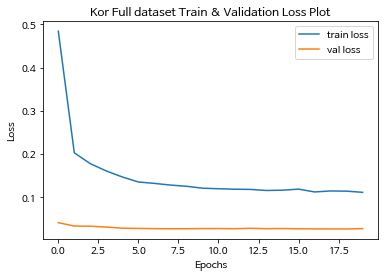

In [52]:
# 훈련, 검증데이터의 Loss 값 그래프
plt.plot(loss_plot, label = 'train loss')
plt.plot(val_loss_plot, label = 'val loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Kor Full dataset Train & Validation Loss Plot')
plt.legend()
plt.show()

## 캡셔닝

- 각 타임스텝에서 decoder는 Decoder의 hidden state, encoder 출력값 그리고 이전 예측값을 입력값으로 받습니다.
- 모델이 end 토큰을 예측하면 예측이 중지됩니다.
- 그리고 타임스텝마다 attention 가중치를 저장합니다.

In [53]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [54]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for i in range(len_result):
        temp_att = np.resize(attention_plot[i], (8, 8))
        
        grid_size = max(np.ceil(len_result/2), 2)
        grid_size = max(np.ceil(len_result/4), 4)
        grid_size = max(np.ceil(len_result/8), 8)
        ax = fig.add_subplot(grid_size, grid_size, i+1)
        ax.set_title(result[i])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.5, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

# 실험
- 이 모델에게 새로운 이미지를 주고, 제대로 학습이 이루어졌는지 확인해봅시다. 
- 물론, Dataset 이외의 데이터를 주게 되면, 실험 결과가 부정확할 확률이 높습니다.
- 아래 URL을 바꾸면 이미지를 바꿀 수 있습니다. 

In [55]:
import warnings
warnings.filterwarnings(action='default')
plt.rc('font', family='Malgun Gothic')

Prediction Caption: 고추에 이상 징후가 발견되지 않아 정상 고추로 사료됩니다




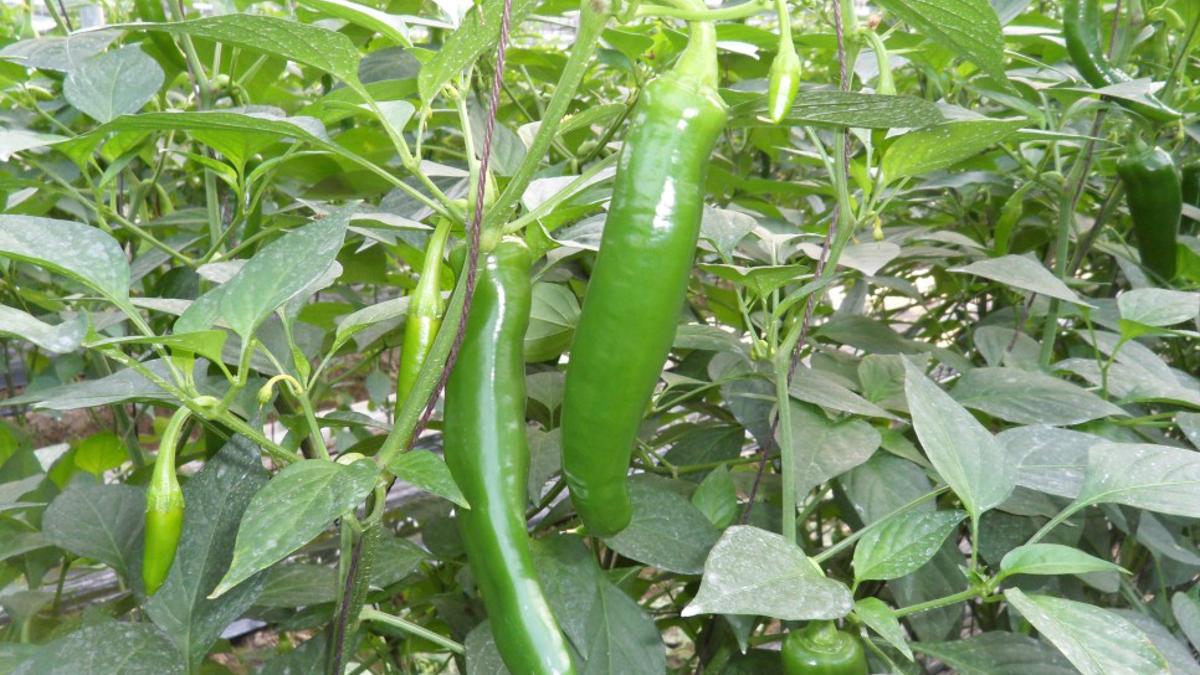

In [69]:
image_url = 'https://k-farmers.co.kr/wp-content/uploads/2021/09/blog_nong-up_222008836518_1.jpg'
image_extension = image_url[-4:]
# print(image_extension)
image_path = tf.keras.utils.get_file('image'+image_extension, origin=image_url)
# print(image_path)


result, attention_plot = evaluate(image_path)
result_join = ' '.join(result)
result_final = result_join.rsplit(' ', 1)[0] #<end> 토큰 없애기

print('Prediction Caption:', result_final)
print()
print()
#plot_attention(image_path, result, attention_plot)
# opening the image
Image.open(image_path)

# 이미지 캡셔닝 모델 평가
- BLEU스코어, 실제 캡션, 모델이 생성한 캡션을 비교


In [81]:
def generate_caption():
    start_token = tokenizer.word_index['<start>']
    end_token = tokenizer.word_index['<end>']

    #검증 데이터셋에서 랜덤으로 이미지를 선택한다
    rid = np.random.randint(0, len(img_name_val)) #랜덤 아이디
    image = img_name_val[rid]
    real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
    result,attention_weights = evaluate(image)

    first = real_caption.split(' ', 1)[1]
    real_caption = first.rsplit(' ', 1)[0]


    for i in result:
        if i=="<unk>":
            result.remove(i)

    for i in real_caption:
        if i=="<unk>":
            real_caption.remove(i)

    #결과(result)에서 <end> 토큰을 제거한다
    result_join = ' '.join(result)
    result_final = result_join.rsplit(' ', 1)[0]

    real_appn = []
    real_appn.append(real_caption.split())
    reference = real_appn
    candidate = result

    score = sentence_bleu(reference, candidate, weights=(1.0,0,0,0))
    print(f"BLEU-1 score: {score*100}")
    score = sentence_bleu(reference, candidate, weights=(0.5,0.5,0,0))
    print(f"BLEU-2 score: {score*100}")
    score = sentence_bleu(reference, candidate, weights=(0.3,0.3,0.3,0))
    print(f"BLEU-3 score: {score*100}")
    score = sentence_bleu(reference, candidate, weights=(0.25,0.25,0.25,0.25))
    print(f"BLEU-4 score: {score*100}")

    print()

    print('Real Caption:', real_caption)
    print('Predicted Caption:', result_final) #' '.join(result)
    print()
    temp_image = np.array(Image.open(image))
    plt.axis('off')
    plt.imshow(temp_image)
    print('Image:\n', image)

BLEU-1 score: 77.77777777777779
BLEU-2 score: 69.72166887783963
BLEU-3 score: 62.46368891901789
BLEU-4 score: 43.167001068522524

Real Caption: 원형반점과 황갈색의 포자가 나타나는 것으로 보아 고추탄저병으로 의심됩니다
Predicted Caption: 원형반점과 황갈색의 포자가 생긴 것으로 보아 고추탄저병으로 의심됩니다

Image:
 /content/drive/MyDrive/pepper_dataset/plant_dataset/노지 작물 질병 진단 이미지/고추전체/고추이미지all/V006_79_1_01_01_01_13_2_5430z_20200921_22_a0000.JPG


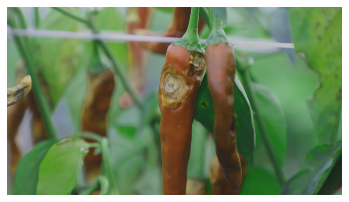

In [83]:
generate_caption()

BLEU-1 score: 50.0
BLEU-2 score: 42.640143271122085
BLEU-3 score: 41.78568918931313
BLEU-4 score: 33.18077402843942

Real Caption: 고추에 잎에 담황색 반점무늬가 발견되어 고추흰가루병으로 의심됩니다
Predicted Caption: 고추에 이슬과 같은 연한 흰색 곰팡이와 담황색 반점무늬가 발견되어 고추흰가루병으로 의심됩니다

Image:
 /content/drive/MyDrive/pepper_dataset/plant_dataset/노지 작물 질병 진단 이미지/고추전체/고추이미지all/V006_79_1_02_01_03_13_2_3068z_20201102_2_a0007.JPG


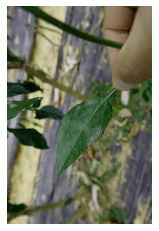

In [84]:
generate_caption()

BLEU-1 score: 46.666666666666664
BLEU-2 score: 36.51483716701108
BLEU-3 score: 35.19127417744587
BLEU-4 score: 26.760322756637912

Real Caption: 담황색 반점무늬와 연한 흰색 곰팡이가 잎에 나타나는 것으로 보아 고추흰가루병으로 의심됩니다
Predicted Caption: 잎에 담황색 병무늬와 밀가루 바른 것과 같은 증상이 넓게 나타나는 것으로 보아 고추흰가루병으로 의심됩니다

Image:
 /content/drive/MyDrive/pepper_dataset/plant_dataset/노지 작물 질병 진단 이미지/고추전체/고추이미지all/V006_79_1_02_01_03_13_3_0149z_20201021_18_a0000.JPG


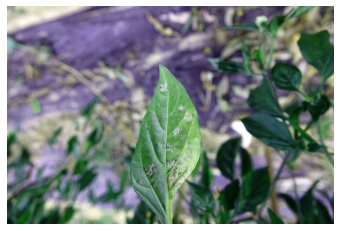

In [88]:
generate_caption()